In [1]:
import rescomp as rc
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from scipy.interpolate import CubicSpline
plt.rcParams["figure.figsize"] = [10, 10]

In [2]:
def orbit_fft(t, U):
    T = float(t[-1] - t[0])
    N = len(t)
    Uf = sp.fft.fft(U, axis=0)/N
    Uf = 2*np.abs(Uf[:int(N/2),:])
    xf = np.arange(0, int(N/2)) / T
    return xf, Uf

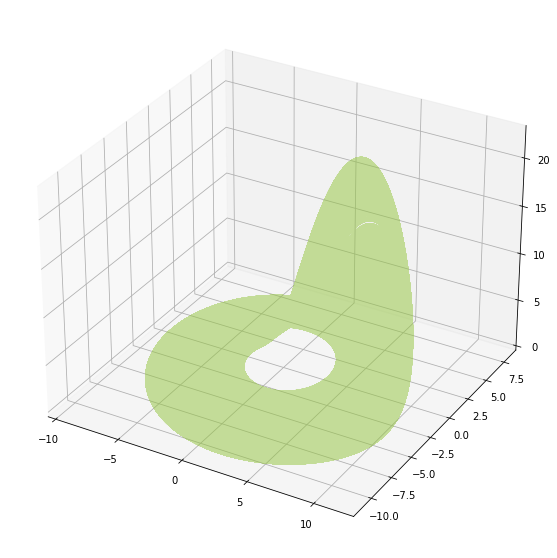

array([0.57768724, 0.77383773, 0.23708642])

In [3]:
t, U = rc.orbit("rossler", duration=10000)
rc.plot3d(U)

# Long Term Rossler Frequency Spectrum

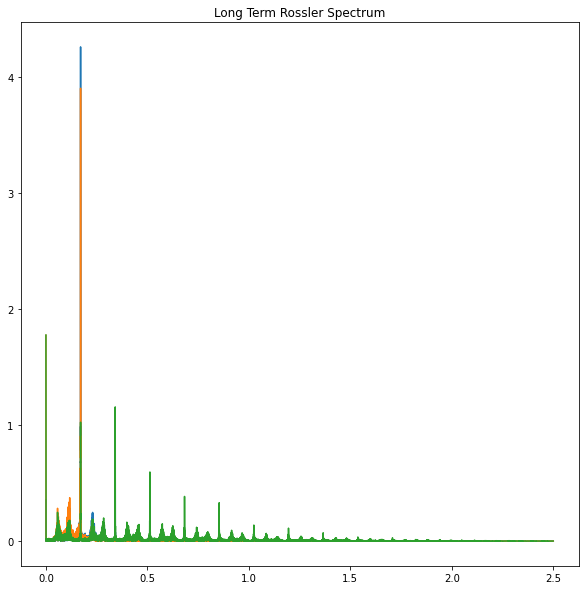

In [4]:
xf, Uf = orbit_fft(t, U)
mask = xf < 2.5
plt.plot(xf[mask], Uf[mask,:])
plt.title("Long Term Rossler Spectrum")
plt.show()

# Short Term Rossler Frequency Spectrum

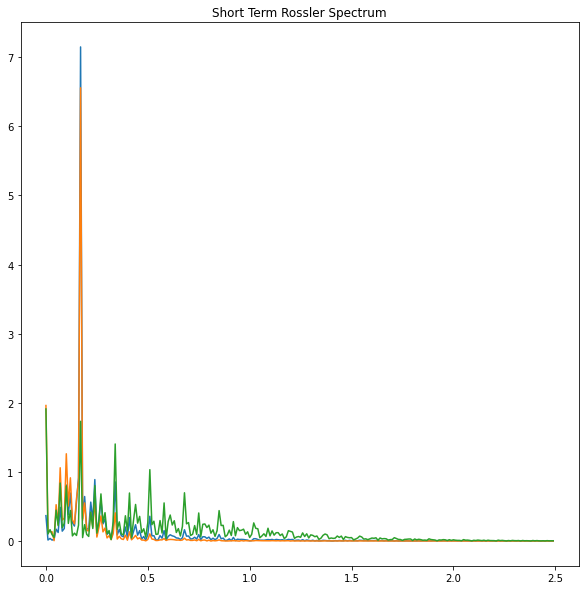

In [5]:
st, sU = rc.orbit("rossler", duration=100)
sxf, sUf = orbit_fft(st, sU)
mask = sxf < 2.5
plt.plot(sxf[mask], sUf[mask,:])
plt.title("Short Term Rossler Spectrum")
plt.show()

## Convergence of Rossler Spectrum as $t \rightarrow \infty$

In [8]:
hz = np.linspace(0.1, 10, 50000)
meanuf = CubicSpline(xf, meanUf)
N = 10
durations = [2, 5, 10, 50, 100, 1000, 2000, 3000, 4000, 5000, 10000]
L2 = np.zeros(len(durations))
Linf = np.zeros(len(durations))
for i, T in enumerate(durations):
    for _ in range(N):
        st, sU = rc.orbit("rossler", duration=T, trim=clip)
        sxf, sUf = orbit_fft(st, sU)
        suf = CubicSpline(sxf, sUf)
        diff = suf(hz) - meanuf(hz)
        L2[i] += np.mean(np.sum(diff**2, axis=0)**0.5)
        Linf[i] += np.max(np.abs(diff))
    L2[i] /= N
    Linf[i] /= N
        
    print(f"Time Duration: {T} L2: {L2[i]} Linf: {Linf[i]} (Mean of {N})")

Time Duration: 2 L2: 203.86278697967703 Linf: 7.909969413335391 (Mean of 10)
Time Duration: 5 L2: 136.2693920199948 Linf: 6.460404851680567 (Mean of 10)
Time Duration: 10 L2: 123.74269917060792 Linf: 6.328184943845508 (Mean of 10)
Time Duration: 50 L2: 56.52923233098702 Linf: 4.976766495233724 (Mean of 10)
Time Duration: 100 L2: 38.02199751277578 Linf: 6.472709967710401 (Mean of 10)
Time Duration: 1000 L2: 9.927091561845858 Linf: 5.331981652398801 (Mean of 10)
Time Duration: 2000 L2: 6.101884854107799 Linf: 3.6580634407533843 (Mean of 10)
Time Duration: 3000 L2: 3.8012369166521145 Linf: 2.6579590364402526 (Mean of 10)
Time Duration: 4000 L2: 2.697609298818622 Linf: 1.5679982831823067 (Mean of 10)
Time Duration: 5000 L2: 2.5209162292534155 Linf: 1.6389153218907047 (Mean of 10)
Time Duration: 10000 L2: 2.6085216677051646 Linf: 2.451679410087125 (Mean of 10)


# Reservoir Parameters

In [10]:
# Initial guesses
PRMS = {
    "res_sz": 100,
    "activ_f": np.tanh,
    "mean_degree": 2.0,
    "ridge_alpha": 1e-6,
    "spect_rad": 2.0,
    "gamma": 10.,
    "sigma": .1,
    "uniform_weights": True,
    "sparse_res": True,
    "signal_dim": 3
}

def fouriernorm(xf1, Uf1, xf2, Uf2, order=2):
        uf1 = CubicSpline(xf1, Uf1)
        uf2 = CubicSpline(xf2, Uf2)
        hz = np.linspace(0.1, 50, 50000)
        diff = uf1(hz) - uf2(hz)
        if order == 2:
            # L2 Norm
            return np.mean(np.sum(diff**2, axis=0)**0.5)
        if order == "inf":
            # L-infinity norm
            return np.max(np.abs(diff))

In [137]:
Uf.shape

(499999, 3)

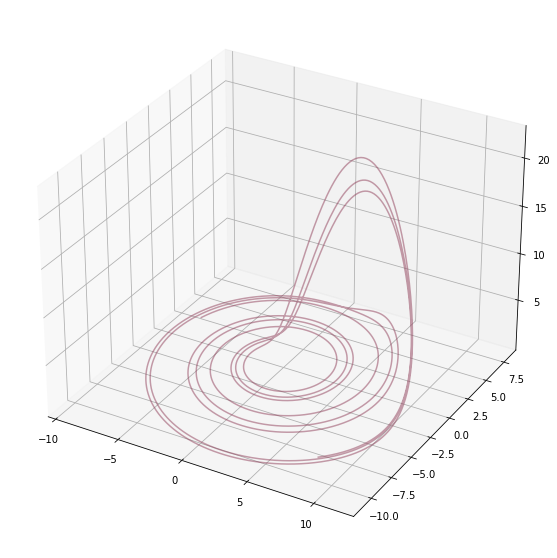

array([0.56252994, 0.24098668, 0.34396678])

In [85]:
t, U = rc.orbit("rossler", duration=50, trim=True)
rc.plot3d(U)

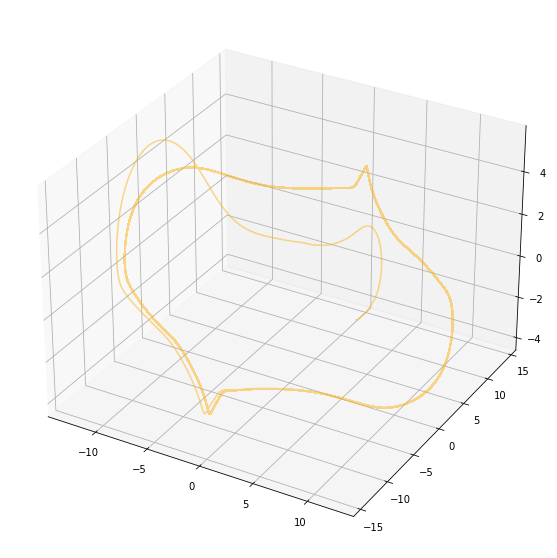

Fourier Norm:  7013.449281648954


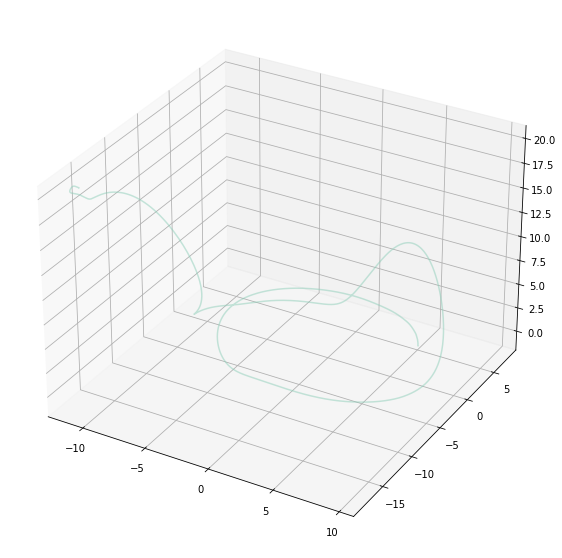

Fourier Norm:  617.7391497218035


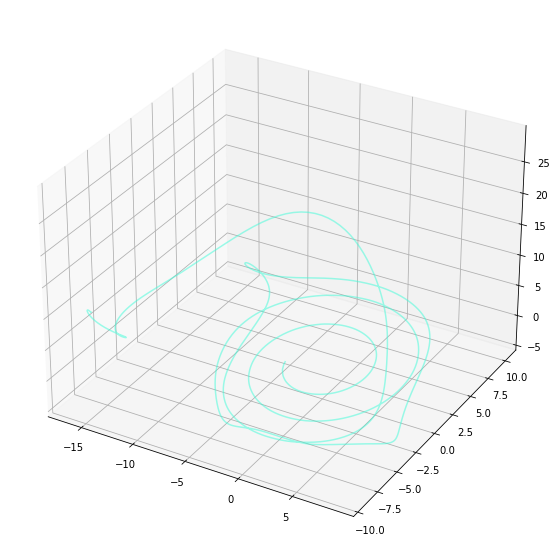

Fourier Norm:  687.5732448348872


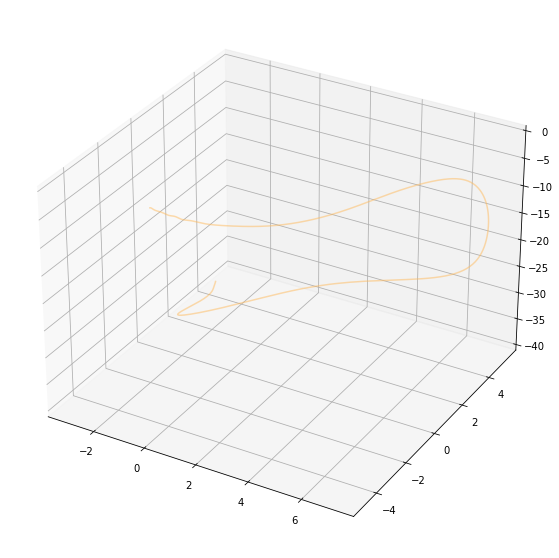

Fourier Norm:  248.5931851174821


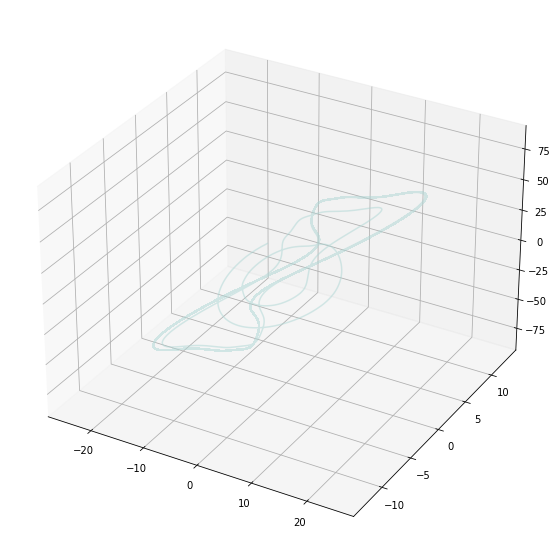

Fourier Norm:  265.7926204808344


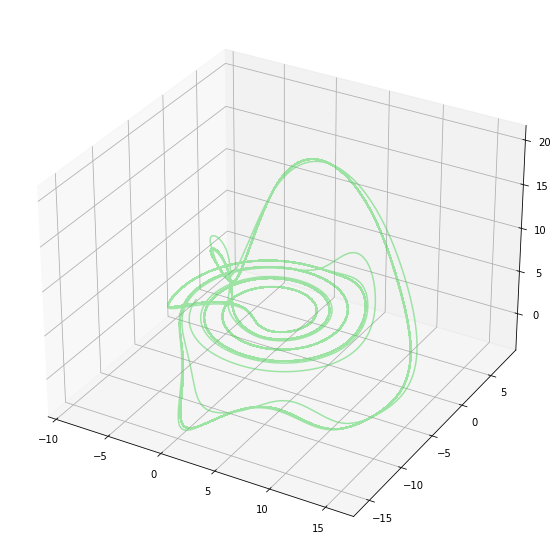

Fourier Norm:  4632.433332239819


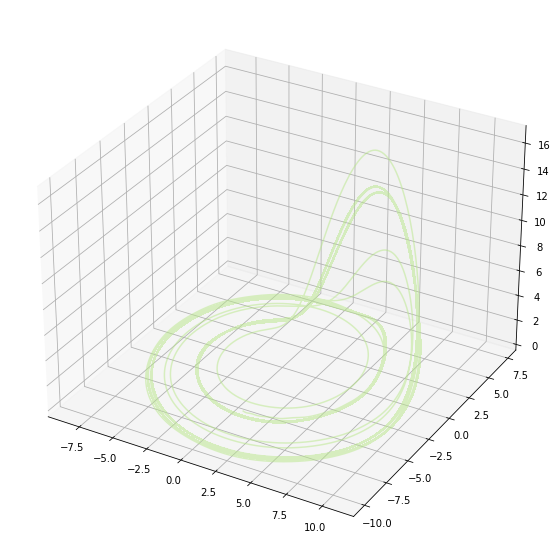

Fourier Norm:  4769.020560090895


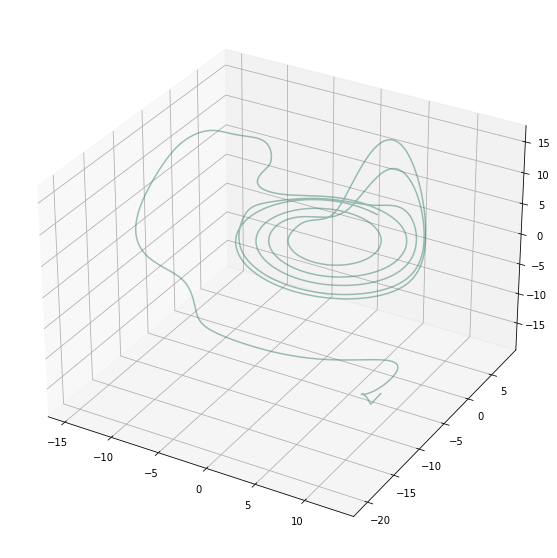

Fourier Norm:  946.3723851886867


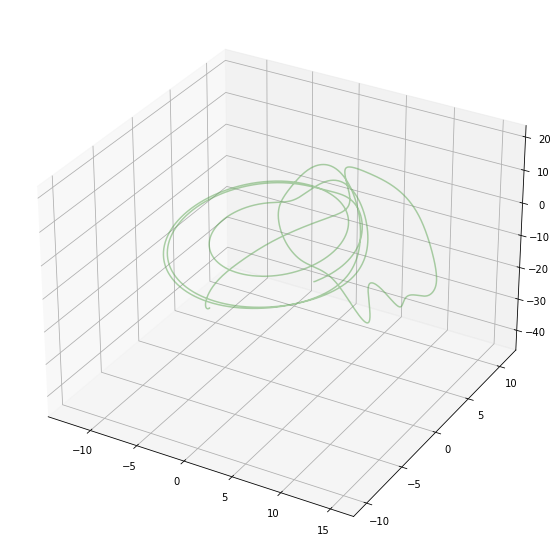

Fourier Norm:  1357.4032913516216


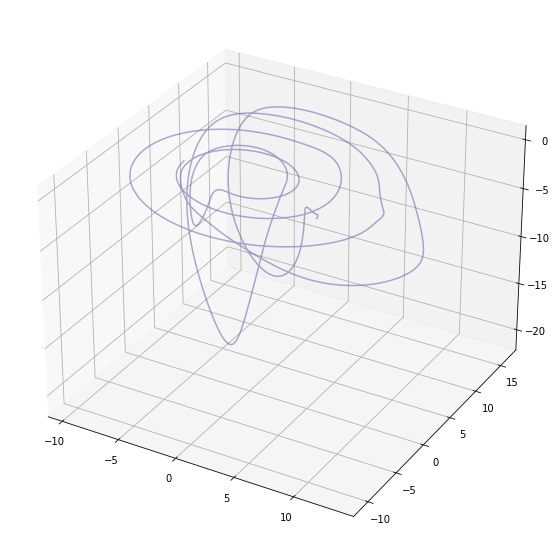

Fourier Norm:  717.2677535490649


In [13]:
for i in range(10):
    t, U = rc.orbit("rossler", duration=50, trim=True)
    xf0, Uf0 = orbit_fft(t, U)
    rcomp = rc.ResComp(**PRMS)
    rcomp.train(t, U)
    u0 = U[0,:] + np.random.randn(3)*1e-4
    ts = np.arange(0, 10000, .01)
    pre = rcomp.predict(ts, u0)
    rc.plot3d(pre)
    xf0, Uf0 = orbit_fft(t, pre)
    print("Fourier Norm: ", fouriernorm(xf0, Uf0, xf, meanUf, order=2))

In [16]:
PRMS2 = {
    "res_sz": 100,
    "activ_f": np.tanh,
    "mean_degree": 1.5,
    "ridge_alpha": 1e-8,
    "spect_rad": 2.0,
    "gamma": 5.,
    "sigma": .05,
    "uniform_weights": True,
    "sparse_res": True,
    "signal_dim": 3
}

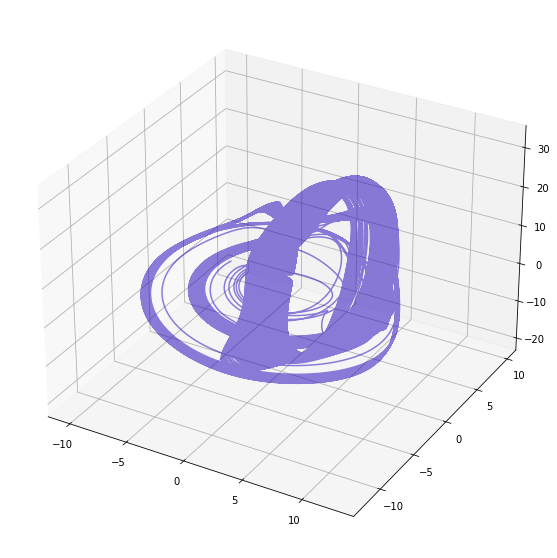

Fourier Norm:  4881.100841263698


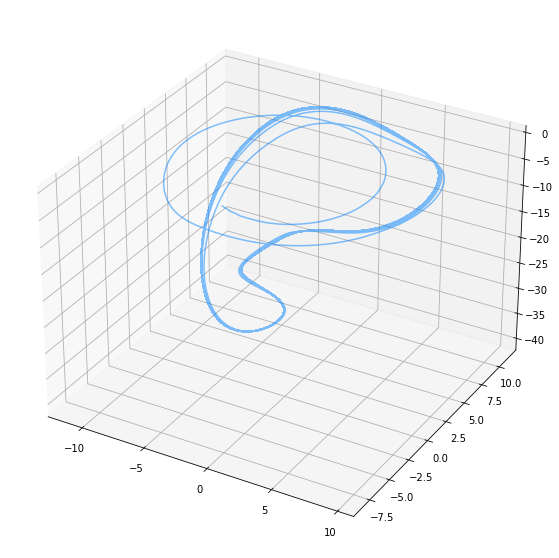

Fourier Norm:  7205.25487369954


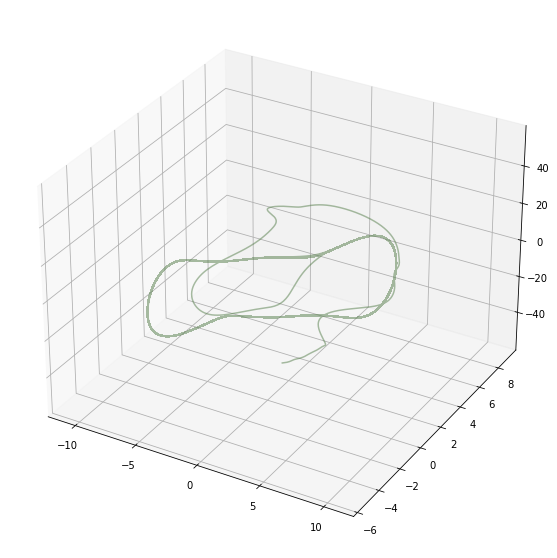

Fourier Norm:  414.9294314356219


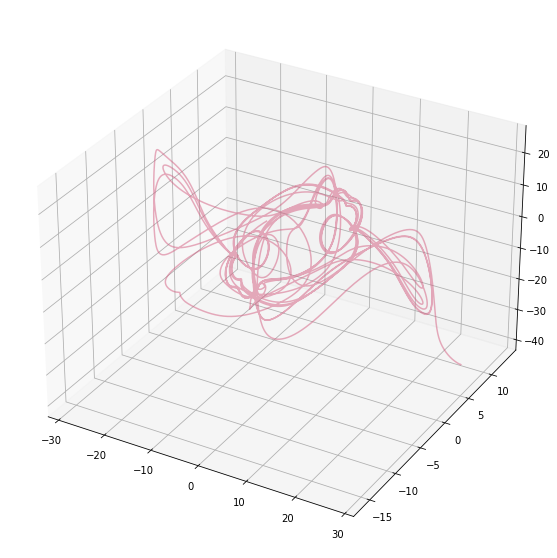

Fourier Norm:  3080.8290391083488


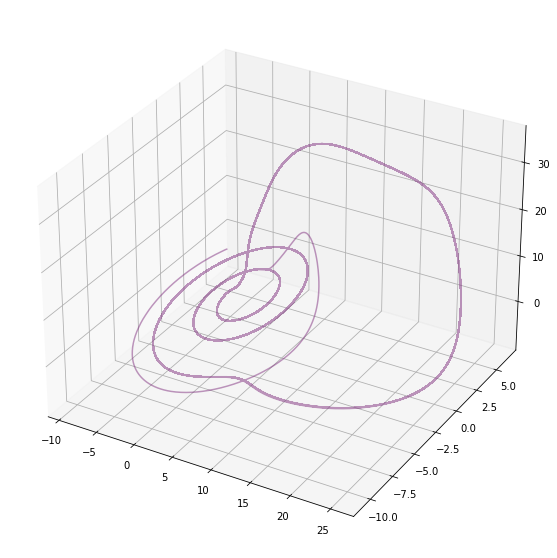

Fourier Norm:  5059.5148009736595


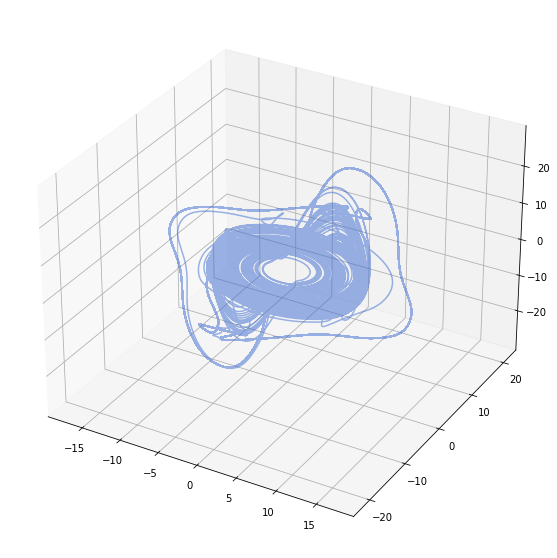

Fourier Norm:  9592.03024055511


KeyboardInterrupt: 

In [17]:
for i in range(10):
    t, U = rc.orbit("rossler", duration=50, trim=True)
    xf0, Uf0 = orbit_fft(t, U)
    rcomp = rc.ResComp(**PRMS)
    rcomp.train(t, U)
    u0 = U[0,:] + np.random.randn(3)*1e-4
    ts = np.arange(0, 10000, .01)
    pre = rcomp.predict(ts, u0)
    rc.plot3d(pre)
    xf0, Uf0 = orbit_fft(t, pre)
    print("Fourier Norm: ", fouriernorm(xf0, Uf0, xf, meanUf, order=2))